# Unsupervised Anomaly Detection with Isolation Forest

This notebook applies an unsupervised anomaly detection pipeline to the dataset in `test.csv`.  
The main goal is to identify data points that behave very differently from the majority, and then
generate a submission file containing:

- `id` – the original sample identifier from the dataset
- `is_anomaly` – binary label predicted by the Isolation Forest model  
  (`1` = anomaly, `0` = normal)

The workflow consists of:

1. Environment and library configuration  
2. Data loading and basic inspection  
3. Numeric feature selection and preprocessing  
4. Training the Isolation Forest model  
5. Visualizing anomaly scores and flagged points  
6. Exporting predictions to `submission.csv` for downstream use


In [14]:
# ============================================
# Warnings & Notebook Display Config
# ============================================
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

# Plot config for Jupyter
%config InlineBackend.figure_formats = {'png', 'retina'}

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ============================================
# Core Libraries
# ============================================
from platform import python_version

import numpy as np
import scipy as sp
from scipy import stats

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as stm
import statsmodels.api as sm

print('Python version   :', python_version())
print('Numpy version    :', np.__version__)
print('Scipy version    :', sp.__version__)
print('Pandas version   :', pd.__version__)
print('Matplotlib version:', mpl.__version__)
print('Seaborn version  :', sns.__version__)
print('Statsmodels ver. :', stm.__version__)


Python version   : 3.12.12
Numpy version    : 2.0.2
Scipy version    : 1.16.3
Pandas version   : 2.2.2
Matplotlib version: 3.10.0
Seaborn version  : 0.13.2
Statsmodels ver. : 0.14.5


## Environment Setup

In this section, we:

- Configure warning filters to suppress non-critical messages
- Set plotting backends and styles for clearer visualizations
- Import the core libraries required for:
  - Numerical computation (`numpy`, `scipy`)
  - Data manipulation (`pandas`)
  - Visualization (`matplotlib`, `seaborn`)
  - Statistical modeling (`statsmodels`)
  - Machine learning and deep learning (`scikit-learn`, `tensorflow.keras`)

We also fix a global random seed (`RANDOM_STATE = 42`) to make the results
reproducible across runs.


In [15]:
# ============================================
# Plotting Style
# ============================================
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.grid'] = False

sns.set_style("whitegrid", {'axes.grid': False})

# ============================================
# ML Imports
# ============================================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading and Initial Inspection

Here we load the dataset `test.csv` into a `pandas` DataFrame and perform a quick
sanity check:

- View the overall shape (number of rows and columns)
- Display the first few rows
- Inspect data types and missing values with `df.info()`

This helps us understand what features are available and whether there are
obvious issues such as missing values or non-numeric columns that require
preprocessing.


In [4]:
# ============================================
# Load Dataset
# ============================================

df = pd.read_csv("test.csv")
print("Shape:", df.shape)
df.head()
df.info()

Shape: (25889, 124)


,id,player_id,login_count_1,login_count_2,login_count_3,login_count_4,login_lat_1,login_lon_1,login_lat_2,login_lon_2,...,guild_changes_1,guild_changes_2,guild_changes_3,guild_changes_4,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale
0,ANS00001,P011753,31.222232,41.790417,28.048736,NaN,-17.074035,127.285635,-17.554811,126.865553,...,1.0,2.0,2.0,1.0,580.020715,0.830282,0.0,1.0,0.0,0.0
1,ANS00002,P010021,61.358999,49.209284,NaN,NaN,48.430879,25.555743,48.708993,26.733951,...,0.0,-1.0,-1.0,1.0,1306.627890,0.700770,0.0,NaN,0.0,0.0
2,ANS00003,P006725,24.763478,37.723228,26.879628,32.503285,8.252684,40.788695,8.346856,40.688039,...,0.0,1.0,-1.0,0.0,835.638378,0.797991,0.0,0.0,0.0,0.0
3,ANS00004,P018170,82.100747,74.862388,73.520927,83.495309,-28.728293,178.990465,-29.104994,178.810800,...,2.0,2.0,1.0,3.0,NaN,0.736845,0.0,NaN,0.0,0.0
4,ANS00005,P003027,50.901216,70.636572,55.606357,68.179388,-46.833704,167.886402,-47.372141,166.767058,...,NaN,-1.0,0.0,0.0,379.053416,0.818901,NaN,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25889 entries, 0 to 25888
Columns: 124 entries, id to mass_item_sale
dtypes: float64(122), object(2)
memory usage: 24.5+ MB


<Figure size 500x200 with 0 Axes>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

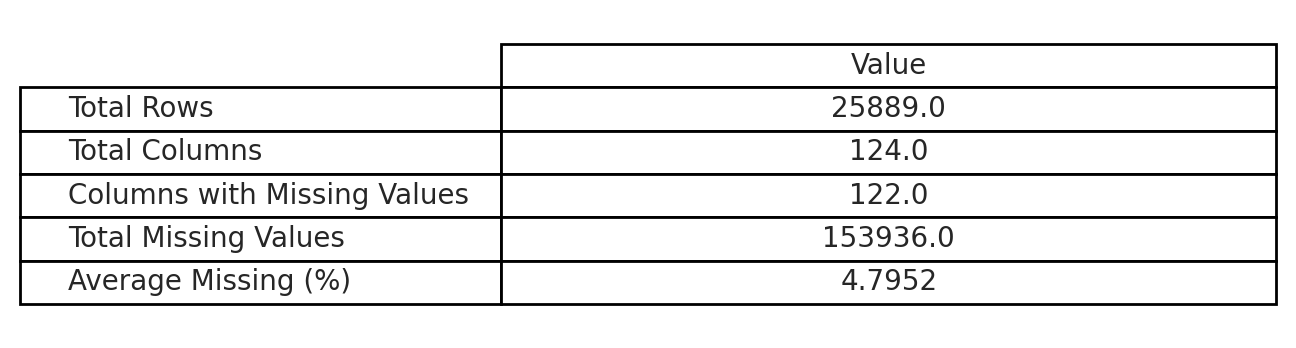

In [50]:
# Calculate missing stats
total_cells = df.shape[0] * df.shape[1]
total_missing = df.isna().sum().sum()
missing_percent = (total_missing / total_cells) * 100
cols_with_missing = (df.isna().sum() > 0).sum()
missing_percent = round(missing_percent, 4)

summary_table = pd.DataFrame({
    "Value": [
        df.shape[0],
        df.shape[1],
        cols_with_missing,
        total_missing,
        missing_percent
    ]
}, index=[
    "Total Rows",
    "Total Columns",
    "Columns with Missing Values",
    "Total Missing Values",
    "Average Missing (%)"
])

plt.figure(figsize=(5, 2))
plt.axis('off')

tbl = plt.table(
    cellText=summary_table.values,
    rowLabels=summary_table.index,
    colLabels=summary_table.columns,
    cellLoc='center',
    loc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)

plt.savefig("missing_summary.png", dpi=300, bbox_inches='tight')
plt.show()


## Feature Selection: Numeric Columns Only

Most unsupervised anomaly detection algorithms (including Isolation Forest)
expect a purely numeric feature matrix.

In this step, we:

- Identify and drop ID-like columns such as `id` or `player_id` that do not
  carry informative signal for anomaly detection.
- Keep only numeric columns using `select_dtypes(include=['number'])`.

The resulting `numeric_df` is the base feature set we will use for all subsequent
modeling steps.


In [19]:

# ============================================
# Basic Numeric Feature Setup
# (drop obvious non-features like ids)
# ============================================
id_like_cols = ['id', 'player_id']
existing_id_cols = [c for c in id_like_cols if c in df.columns]

# keep only numeric features, drop ids / label-like columns
numeric_df = df.drop(columns=existing_id_cols, errors='ignore').select_dtypes(include=['number'])

print("Numeric feature shape:", numeric_df.shape[1])
display(numeric_df.describe().T)

Numeric feature shape: 122


,count,mean,std,min,25%,50%,75%,max
login_count_1,24664.0,59.168038,24.382716,8.681218,38.379785,58.207847,78.067660,118.481216
login_count_2,24620.0,59.252681,25.647370,6.771318,38.114418,57.316760,77.630937,128.474795
login_count_3,24661.0,59.141820,24.982790,8.168783,38.168395,57.721300,77.486436,123.552919
login_count_4,24569.0,59.108049,23.822515,7.802166,38.606611,58.437790,78.523744,113.751919
login_lat_1,24619.0,0.011657,34.528865,-61.082098,-29.714988,-0.047400,29.961480,60.927973
...,...,...,...,...,...,...,...,...
behavior_stability,24654.0,0.818170,0.090880,0.201427,0.759536,0.822190,0.885666,0.949999
password_changed,24638.0,0.060557,0.238521,0.000000,0.000000,0.000000,0.000000,1.000000
vpn_usage,24705.0,0.161061,0.367594,0.000000,0.000000,0.000000,0.000000,1.000000
suspicious_login_time,24605.0,0.050315,0.218599,0.000000,0.000000,0.000000,0.000000,1.000000


## Preprocessing: Imputation and Standardization

Real-world datasets often contain missing values and features with different
scales.

To prepare the data for modeling, we:

1. **Impute missing values** using the median of each feature  
   (`SimpleImputer(strategy="median")`).  
   Median imputation is robust to outliers and works well for skewed
   distributions.

2. **Standardize features** to have zero mean and unit variance  
   (`StandardScaler`).  
   This prevents features with large scales from dominating the model and
   makes distance-based methods more stable.

The preprocessed array `X_scaled` is the final input to our anomaly detection
model.


In [7]:
# ============================================
# Preprocessing: Impute + Scale
# ============================================
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imp = imputer.fit_transform(numeric_df)
print("NaN count BEFORE imputation:", numeric_df.isna().sum().sum())
print("NaN count AFTER  imputation:", np.isnan(X_imp).sum())
X_scaled = scaler.fit_transform(X_imp)

print("Preprocessed feature matrix shape:", X_scaled.shape)

NaN count BEFORE imputation: 153936
NaN count AFTER  imputation: 0
Preprocessed feature matrix shape: (25889, 122)


## Model: Isolation Forest

We use **Isolation Forest** as the primary anomaly detection model.  
Key ideas:

- Anomalies are observations that are easier to isolate via random splits
  in the feature space.
- The algorithm builds an ensemble of random trees; points that require
  fewer splits to isolate are considered more anomalous.

Important hyperparameters used here:

- `n_estimators = 400`: number of trees in the ensemble  
- `max_samples = 10000`: number of samples used per tree  
- `max_features = 0.8`: fraction of features used at each split  
- `contamination = 0.05`: we assume approximately 5% of the data are anomalies  

The model outputs:

- A continuous **anomaly score** (`iso_score`): higher = more anomalous  
- A binary **anomaly label** (`iso_label`): `1` for anomaly, `0` for normal


In [9]:
def plot_score_distribution_by_label(scores, labels, title="Anomaly Score Distribution"):
    """Plot Isolation Forest score distribution split by normal vs anomaly."""
    scores = np.asarray(scores)
    labels = np.asarray(labels)

    normal_scores  = scores[labels == 0]
    anomaly_scores = scores[labels == 1]

    plt.figure(figsize=(8, 4))

    # Normal score distribution (black-grey)
    sns.histplot(
        normal_scores,
        bins=50,
        kde=False,
        color="#303030",
        alpha=0.6,
        label="Normal (ISO = 0)"
    )

    # Anomaly score distribution (red)
    sns.histplot(
        anomaly_scores,
        bins=50,
        kde=False,
        color="#ff2a2a",
        alpha=0.8,
        label="Anomaly (ISO = 1)"
    )

    # Optional KDE curves for smoother view
    sns.kdeplot(normal_scores,  color="#202020", linewidth=1.5)
    sns.kdeplot(anomaly_scores, color="#ff2a2a", linewidth=1.5)

    # Anomaly stats text box
    total          = len(labels)
    anomalies_count = int(labels.sum())
    percent        = anomalies_count / total * 100

    plt.title(title)
    plt.xlabel("Isolation Forest Anomaly Score (higher = more anomalous)")
    plt.ylabel("Count")
    plt.legend()

    # Text box in top-right
    text_str = f"Anomalies: {anomalies_count} / {total}\n({percent:.2f}%)"
    ax = plt.gca()
    ax.text(
        0.98, 0.95, text_str,
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.show()


IsolationForest(contamination=0.05, max_features=0.8, max_samples=10000,
                n_estimators=400, n_jobs=-1, random_state=42)

Isolation Forest anomalies: 1295 out of 25889 (5.00%)


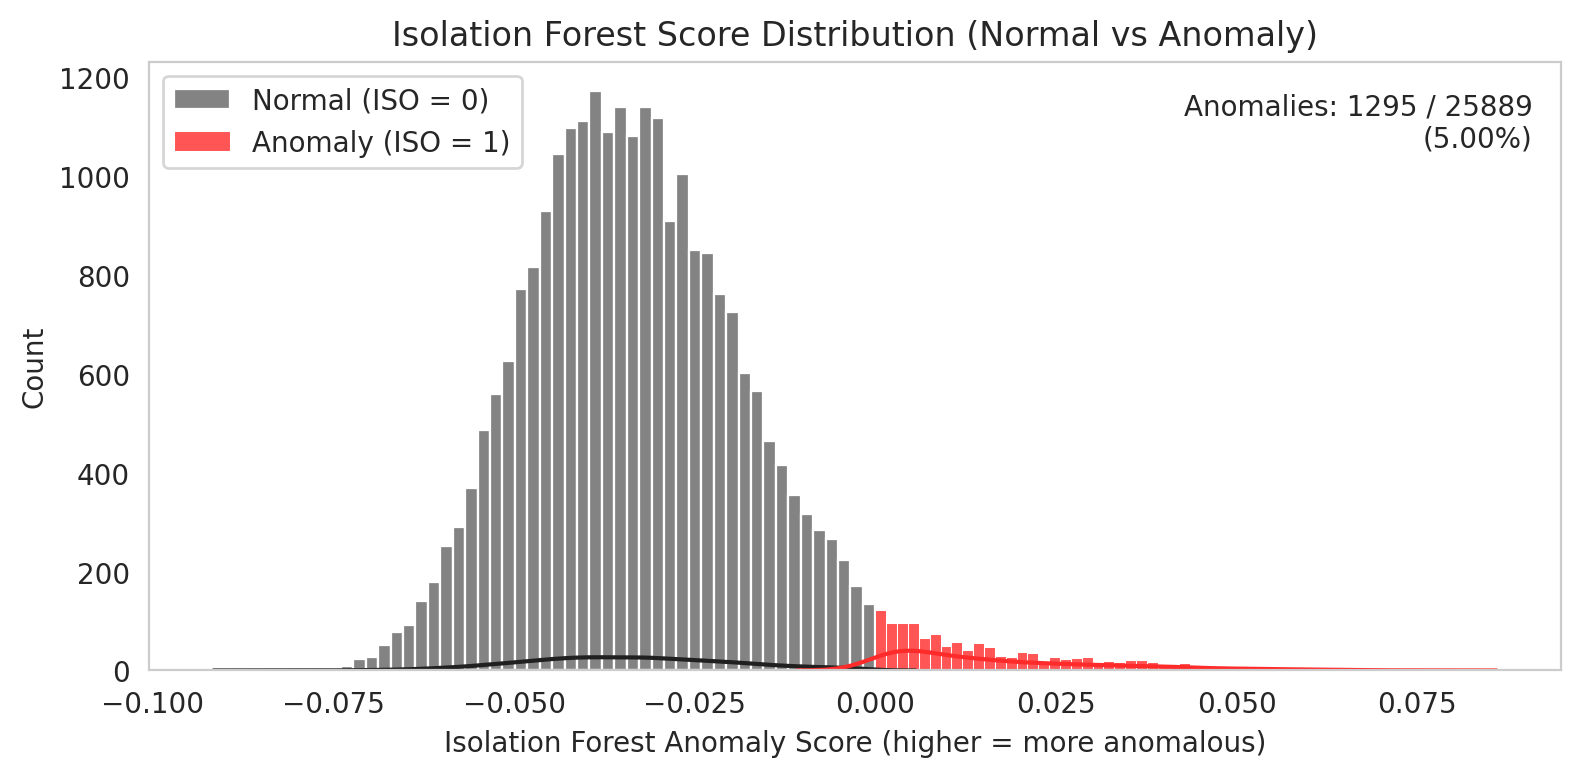

In [10]:
# ============================================
# Model — Isolation Forest
# ============================================

iso = IsolationForest(
    n_estimators=400,
    max_samples=10000,
    max_features=0.8,
    contamination=0.05,   # 5% anomalies
    n_jobs=-1,
    random_state=42
)
iso.fit(X_scaled)

# Raw anomaly scores (higher = more anomalous)
iso_score = -iso.decision_function(X_scaled)

# Label: 1 = anomaly, 0 = normal
iso_label = (iso.predict(X_scaled) == -1).astype(int)

# Count & percentage
total = len(iso_label)
anomalies_count = iso_label.sum()
percent = anomalies_count / total * 100

print(f"Isolation Forest anomalies: {anomalies_count} out of {total} ({percent:.2f}%)")

# New colored, labeled graph
plot_score_distribution_by_label(iso_score, iso_label,
                                 "Isolation Forest Score Distribution (Normal vs Anomaly)")

<Figure size 800x400 with 0 Axes>

Text(0.5, 1.0, 'Isolation Forest - Anomaly Scores (Highlighted Anomalies)')

Text(0.5, 0, 'Sample index')

Text(0, 0.5, 'Anomaly score')

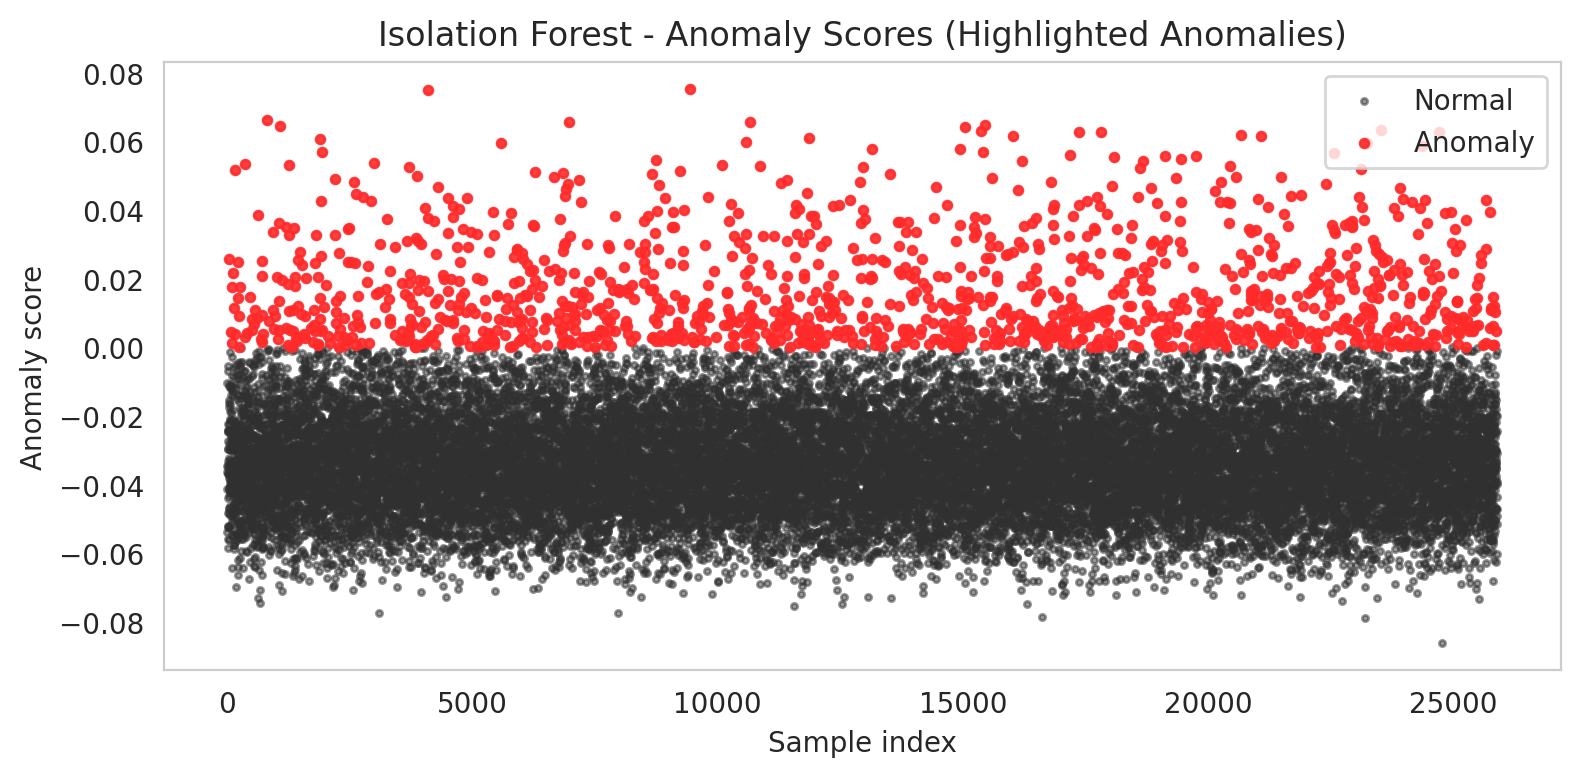

In [11]:
# --------------------------------------------
# Plot : Anomaly score vs sample index
# --------------------------------------------
anomalies = iso_label == 1
normals   = iso_label == 0

idx = np.arange(len(iso_score))

plt.figure(figsize=(8, 4))

# Normal points = dark grey / black-grey
plt.scatter(
    idx[normals],
    iso_score[normals],
    s=5,
    alpha=0.5,
    color="#303030",      # black-grey
    label="Normal"
)

# Anomaly points = bright red
plt.scatter(
    idx[anomalies],
    iso_score[anomalies],
    s=10,
    alpha=0.9,
    color="#ff2a2a",      # strong red
    label="Anomaly"
)

plt.title("Isolation Forest - Anomaly Scores (Highlighted Anomalies)")
plt.xlabel("Sample index")
plt.ylabel("Anomaly score")
plt.legend()
plt.tight_layout()
plt.show()


### PCA 2D Projection: Original Data vs Isolation Forest Anomalies

In this step we project the preprocessed feature matrix `X_scaled` into **two principal components** using PCA in order to visualize the dataset in 2D.

Key points of this plot:

- **Original Data (grey):**  
  All observations from the dataset are shown as semi-transparent grey points.  
  This gives an overview of the overall structure and density of the data in the reduced 2D space.

- **Isolation Forest Anomalies (red):**  
  Points that the Isolation Forest model predicts as anomalies  
  (`iso_label == 1`) are highlighted in red on top of the grey background.  
  These are the observations the model considers most “different” from the bulk of the data.

We also print a short summary showing:

- The total number of samples in the dataset.
- How many of them were flagged as anomalies.
- The corresponding anomaly percentage.

This visualization helps us see whether detected anomalies:

- Lie in sparse or isolated regions of the projected space, or  
- Overlap heavily with dense normal regions (which might suggest a need to
  tune model parameters or reconsider the contamination rate).


X_2d shape: (25889, 2)
Isolation Forest anomalies: 1295/25889 (5.00%)


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'PCA 2D Projection: Original Data vs Isolation Forest Anomalies')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

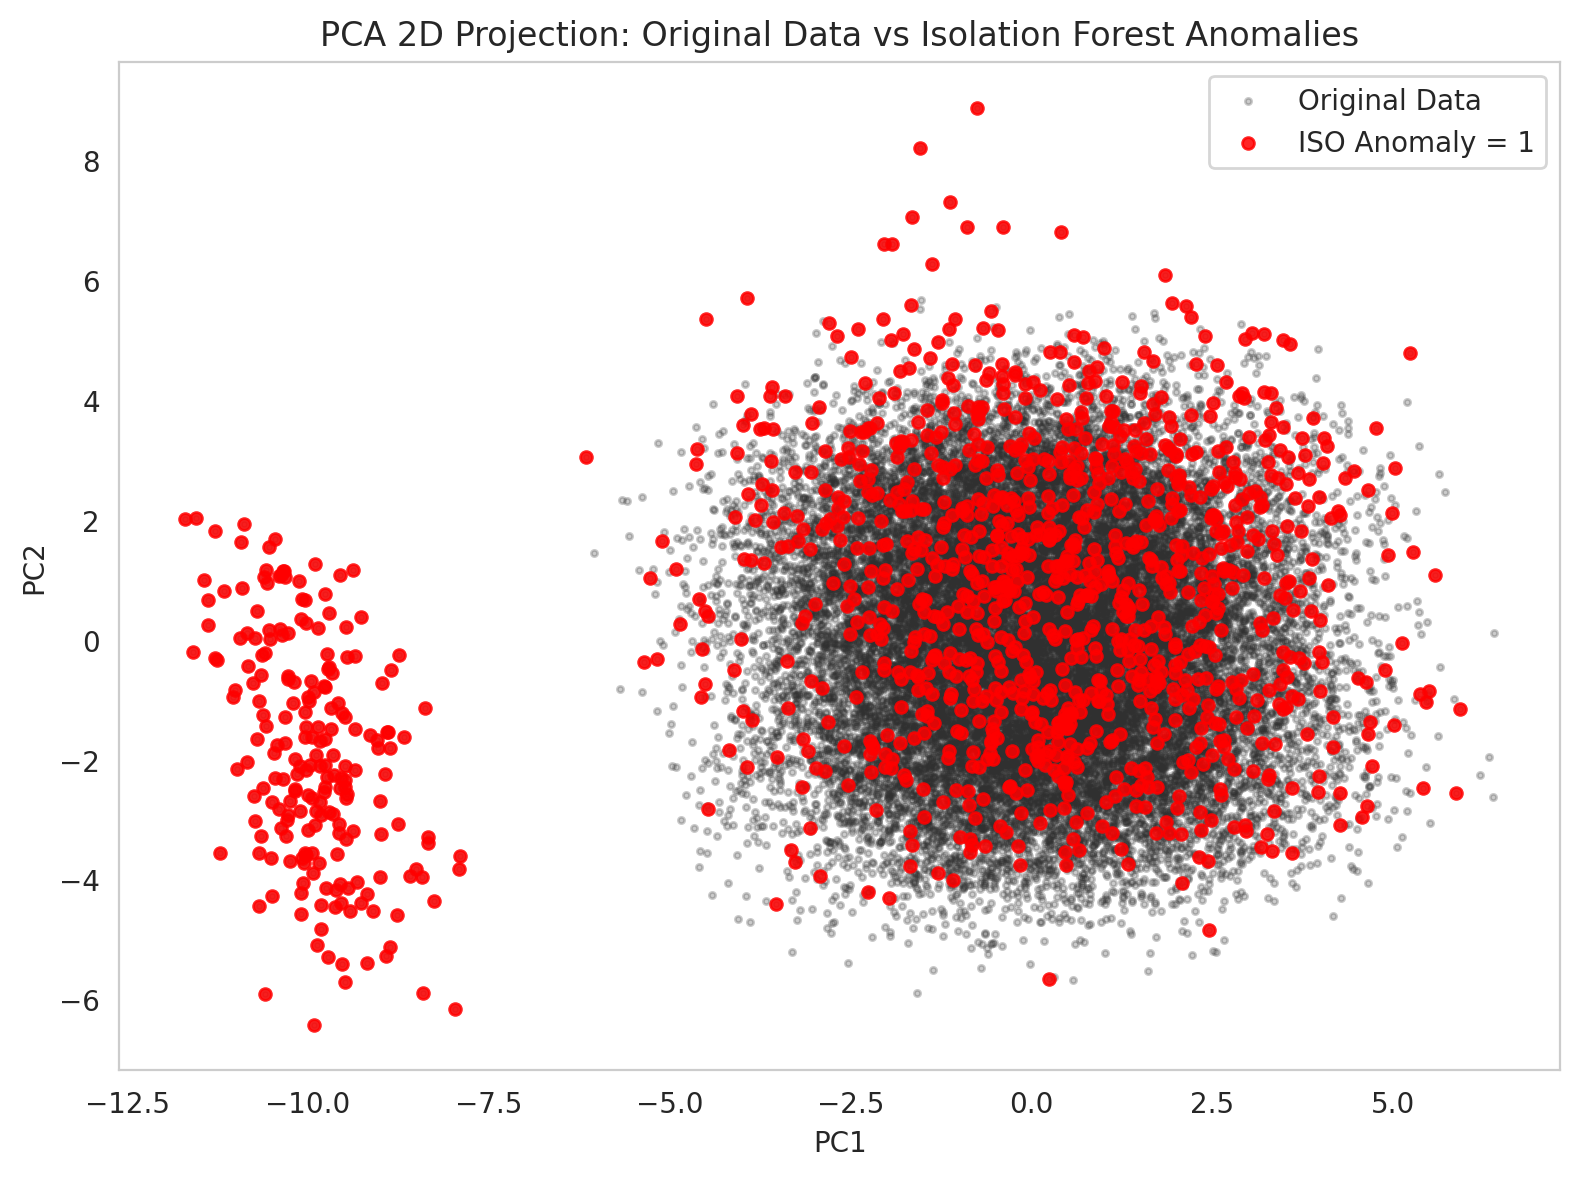

In [52]:
# ============================================
# PCA 2D Projection: Original Data vs ISO Anomalies
# ============================================

# Project to 2D for visualization
pca_vis = PCA(n_components=2, random_state=42)
X_2d = pca_vis.fit_transform(X_scaled)

print("X_2d shape:", X_2d.shape)

# Basic anomaly stats
total_points = len(iso_label)
anomaly_points = int(iso_label.sum())
anomaly_pct = anomaly_points / total_points * 100
print(f"Isolation Forest anomalies: {anomaly_points}/{total_points} ({anomaly_pct:.2f}%)")

plt.figure(figsize=(8, 6))

# Background: all points (original data) in grey
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    s=5, alpha=0.25, color="#303030",
    label="Original Data"
)

# Isolation Forest anomalies in red
plt.scatter(
    X_2d[iso_label == 1, 0], X_2d[iso_label == 1, 1],
    s=18, alpha=0.85, color="red",
    label="ISO Anomaly = 1"
)

plt.title("PCA 2D Projection: Original Data vs Isolation Forest Anomalies")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best")
plt.grid(False)
plt.tight_layout()
plt.show()


## Submission File Construction

For the final step, we build a submission file compatible with the expected
evaluation format.

- We take the `id` column directly from the original DataFrame.
- We attach the binary anomaly label `iso_label` as a new column
  `is_anomaly`.

The resulting DataFrame is saved as `submission.csv` with the following columns:

- `id`
- `is_anomaly`

This file can then be uploaded or used by downstream systems to evaluate the
performance of our anomaly detection approach.


In [13]:
# ============================================
# Prepare submission
# ============================================

submit = df[['id']].copy()      # ใช้ id จากไฟล์เดิม
submit['is_anomaly'] = iso_label.astype(int)  # ใช้ iso_label

print(submit.head())
print(submit['is_anomaly'].value_counts())

submit.to_csv("submission.csv", index=False)
print("Saved submission.csv")

         id  is_anomaly
0  ANS00001           0
1  ANS00002           0
2  ANS00003           0
3  ANS00004           0
4  ANS00005           0
is_anomaly
0    24594
1     1295
Name: count, dtype: int64
Saved submission.csv


## Summary and Limitations

In this notebook, we:

- Performed basic preprocessing (imputation + standardization) on numeric
  features.
- Trained an Isolation Forest model with a contamination rate of 5%.
- Visualized anomaly scores and highlighted anomalous points in both index
  space and PCA-projected space.
- Generated a `submission.csv` file containing `id` and `is_anomaly`.

**Limitations and possible improvements:**

- The contamination rate (5%) is a manual assumption; in practice, this
  should be tuned or validated against labeled data (if available).
- Only one model (Isolation Forest) is used here; an ensemble with other
  methods (e.g., PCA-based reconstruction error, Autoencoder) may yield more
  robust results.
- Feature engineering (e.g., domain-specific transformations) might improve
  separability between normal and abnormal patterns.

These points can be explored in future iterations of the analysis.
